# Feature Engineering Quickstart (Materialized View)

In this example, we'll take some images, create embeddings and captions (if you have a gpu) via a materialized view to demonstrate a feature engineering workflow.

Prerequisites:
* Python 3.10.x
* uv package manager

In [1]:
# specify a path for data to be stored.  Can be on the local filesystem or object store
import tempfile
GENEVA_DB_PATH=tempfile.mkdtemp(prefix="quickstart-mv-")
NUM_IMAGES=100
GENEVA_DB_PATH

# TODO allow relative local paths

'/tmp/quickstart-mv-wl2e8mz6'

In [2]:
%load_ext autoreload
%autoreload 2

## dev mode 
#import sys
# sys.path.append("../src")

## local install 
# ! uv pip install -e .. --extra-index-url https://pypi.fury.io/lancedb

## install from pypi repos
! uv pip install geneva

Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 1 package in 38ms


In [3]:
# dump more logging info
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stderr, force=True)

In [4]:
# geneva version should be >= 0.1.23 
import geneva
import pyarrow as pa
import lance
import lancedb
print(f"geneva {geneva.__version__} lancedb {lancedb.__version__}")

geneva 0.1.28 lancedb 0.23.0


In [5]:
# verify that this machine has GPU
import torch

has_gpu = torch.cuda.is_available()

print("CUDA available:", has_gpu)
if has_gpu:
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU memory (MB):", torch.cuda.get_device_properties(0).total_memory / 1024**2)


CUDA available: True
GPU name: NVIDIA RTX 4000 Ada Generation Laptop GPU
GPU memory (MB): 12281.5


## Let's load some image data

In [6]:
! uv pip install datasets==3.5.0 pillow dill==0.3.7  --upgrade
! uv pip install fsspec --upgrade

/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
⠴ aiohappyeyeballs==2.6.1                                                       Resolved 34 packages in 908ms
Prepared 1 package in 7ms                                                
Uninstalled 1 package in 8ms
Installed 1 package in 56ms                                 
 - fsspec==2025.5.1
 + fsspec==2024.12.0
Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Resolved 1 package in 431ms                                          
Prepared 1 package in 1ms                                                
Uninstalled 1 package in 1ms
Installed 1 package in 27ms                                 
 - fsspec==2024.12.0
 + fsspec==2025.5.1


In [7]:
# Convert a hugging face dataset to lance dataset is easy
import pyarrow as pa
from datasets import load_dataset
import shutil
import io
from geneva.tqdm import tqdm 

shutil.rmtree(GENEVA_DB_PATH, ignore_errors=True)

def load_images():
    dataset = load_dataset("timm/oxford-iiit-pet", split=f"train[:{NUM_IMAGES}]")
    batch = []
    for row in tqdm(dataset):
        buf = io.BytesIO()
        row["image"].save(buf, format="png")
        batch.append({"image": buf.getvalue(), "label": row["label"], "image_id":row["image_id"], "label_cat_dog":row["label_cat_dog"]})
        if len(batch) >= 1024:
            yield pa.RecordBatch.from_pylist(batch)
            batch = []

    if len(batch):
        yield pa.RecordBatch.from_pylist(batch)
db = geneva.connect(GENEVA_DB_PATH)
tbl = db.create_table("images", load_images(), mode="overwrite")
db.table_names()

INFO:datasets:PyTorch version 2.7.1 available.
INFO:datasets:Polars version 1.26.0 available.


  0%|          | 0/100 [00:00<?, ?it/s]

[2025-06-16T22:45:54Z WARN  lance::dataset::write::insert] No existing dataset at /tmp/quickstart-mv-wl2e8mz6/images.lance, it will be created


['images']

[2025-06-16T22:45:54Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


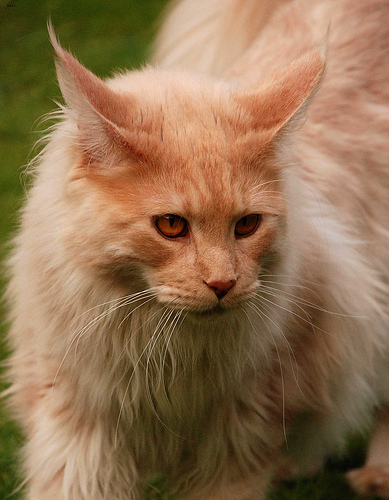

In [8]:
import io
from PIL import Image

df = tbl.to_arrow().to_pandas()
all_images = []
for b in df['image']:
    image_stream = io.BytesIO(b)
    image = Image.open(image_stream)
    all_images.append(image)

all_images[0]

# Let's add some light weight features 
Let's add the dimensions of the image as a column

In [9]:
! uv pip install ray==2.44.1 kubernetes

/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 2 packages in 6ms


In [10]:
# Verify that ray works
import ray
import os

try:
    ray.shutdown()
except:
    pass

# ray.init(num_gpus=1)
ray.init()

/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
2025-06-16 15:45:56,006	INFO worker.py:1852 -- Started a local Ray instance.


Python version:,3.10.16
Ray version:,2.44.1


(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7f68788c2a10>, map_task=CopyTableTask(column_udfs=[ExtractedTransform(output_index=1, output_name='embedding', udf=UDF(func=<__main__.GenEmbeddings object at 0x7f67abc1bee0>, name='GenEmbeddings', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=FixedSizeListType(fixed_size_list<item: float>[512]), version='0.1', checkpoint_key='GenEmbeddings:0.1', field_metadata={})), ExtractedTransform(output_index=2, output_name='caption_blip', udf=UDF(func=<function caption_udf at 0x7f67abcbd090>, name='caption_udf', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='blip', checkpoint_key='caption_udf:blip', field_metadata={}))], view_name='portraits', schema=image: binary pid=491400) embedding: fixed_size_list<item: float>[512]
(ApplierActor(applier=CheckpointingApplier(checkpoint_s

(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7f68788c2a10>, map_task=CopyTableTask(column_udfs=[ExtractedTransform(output_index=1, output_name='embedding', udf=UDF(func=<__main__.GenEmbeddings object at 0x7f67abc1bee0>, name='GenEmbeddings', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=FixedSizeListType(fixed_size_list<item: float>[512]), version='0.1', checkpoint_key='GenEmbeddings:0.1', field_metadata={})), ExtractedTransform(output_index=2, output_name='caption_blip', udf=UDF(func=<function caption_udf at 0x7f67abcbd090>, name='caption_udf', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='blip', checkpoint_key='caption_udf:blip', field_metadata={}))], view_name='portraits', schema=image: binary pid=491400) embedding: fixed_size_list<item: float>[512]
(ApplierActor(applier=CheckpointingApplier(checkpoint_s

(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7f68788c2a10>, map_task=CopyTableTask(column_udfs=[ExtractedTransform(output_index=1, output_name='embedding', udf=UDF(func=<__main__.GenEmbeddings object at 0x7f67abc1bee0>, name='GenEmbeddings', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=FixedSizeListType(fixed_size_list<item: float>[512]), version='0.1', checkpoint_key='GenEmbeddings:0.1', field_metadata={})), ExtractedTransform(output_index=2, output_name='caption_blip', udf=UDF(func=<function caption_udf at 0x7f67abcbd090>, name='caption_udf', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='blip', checkpoint_key='caption_udf:blip', field_metadata={}))], view_name='portraits', schema=image: binary pid=491400) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. 

(autoscaler +41s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +41s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1m17s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [11]:
# Define two simple UDF functions 
from geneva import udf 

@udf
def file_size(image:bytes) -> int:
    return len(image)

# TODO infer structs output types or tuple output types
@udf(data_type=pa.struct([pa.field("width", pa.int32()), pa.field("height", pa.int32())]))
def dimensions(image:bytes) -> (int, int):
    image_stream = io.BytesIO(image)
    img = Image.open(image_stream)
    return img.size

In [12]:
# You can just run the udf to test it.
print(file_size(df["image"][0]))
print(dimensions(df["image"][0]))

342408
(389, 500)


In [13]:
# now let's add the column to the table with the udf as the generator
try: 
    tbl.drop_columns(["file_size", "dimensions"])
except:
    pass
tbl.add_columns({"file_size":file_size, "dimensions":dimensions})

INFO:geneva.table:Adding column: udf={'file_size': UDF(func=<function file_size at 0x7f2ad37a4c10>, name='file_size', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(int64), version='c7678734b662f6bede3587fa6b6d9797', checkpoint_key='file_size:c7678734b662f6bede3587fa6b6d9797', field_metadata={})}
INFO:geneva.table:Adding column: udf={'dimensions': UDF(func=<function dimensions at 0x7f28ea6e9fc0>, name='dimensions', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=StructType(struct<width: int32, height: int32>), version='bb34ce8f7945cda8c1f9dc72019114b0', checkpoint_key='dimensions:bb34ce8f7945cda8c1f9dc72019114b0', field_metadata={})}


In [14]:
tbl.to_pandas()

[2025-06-16T22:45:58Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,NaN,"{'width': None, 'height': None}"
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,NaN,"{'width': None, 'height': None}"
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,NaN,"{'width': None, 'height': None}"
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,NaN,"{'width': None, 'height': None}"
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,NaN,"{'width': None, 'height': None}"
...,...,...,...,...,...,...
95,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_175,1,NaN,"{'width': None, 'height': None}"
96,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,8,boxer_125,1,NaN,"{'width': None, 'height': None}"
97,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_124,1,NaN,"{'width': None, 'height': None}"
98,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,33,Sphynx_173,0,NaN,"{'width': None, 'height': None}"


In [15]:
tbl.backfill("file_size")
tbl.to_pandas()

INFO:geneva.runners.ray.pipeline:carry_forward_cols ['file_size']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[2025-06-16T22:46:01Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
[2025-06-16T22:46:01Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': None, 'height': None}"
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': None, 'height': None}"
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': None, 'height': None}"
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': None, 'height': None}"
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': None, 'height': None}"
...,...,...,...,...,...,...
95,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_175,1,427801,"{'width': None, 'height': None}"
96,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,8,boxer_125,1,326605,"{'width': None, 'height': None}"
97,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_124,1,273734,"{'width': None, 'height': None}"
98,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,33,Sphynx_173,0,245115,"{'width': None, 'height': None}"


In [16]:
tbl.backfill("dimensions")
tbl.to_pandas()

INFO:geneva.runners.ray.pipeline:carry_forward_cols ['dimensions']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[2025-06-16T22:46:03Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
[2025-06-16T22:46:03Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}"
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}"
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}"
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}"
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}"
...,...,...,...,...,...,...
95,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_175,1,427801,"{'width': 500, 'height': 417}"
96,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,8,boxer_125,1,326605,"{'width': 500, 'height': 333}"
97,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_124,1,273734,"{'width': 333, 'height': 500}"
98,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,33,Sphynx_173,0,245115,"{'width': 500, 'height': 375}"


# Load embedding library

In [17]:
!uv pip install open-clip-torch
!uv pip install scikit-learn
!uv pip install matplotlib

/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 1 package in 14ms
Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 1 package in 4ms
Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 1 package in 4ms


# Let's do some curation and filtering

Let's say we want to do a sample and just focus on portrait mode images (height > width)

In [18]:
portrait_q = tbl.search().where("dimensions.height > dimensions.width") 
portrait = portrait_q.to_arrow().to_pandas()
portrait


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}"
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}"
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_123,1,93251,"{'width': 223, 'height': 300}"
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_124,1,335037,"{'width': 375, 'height': 500}"
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_135,1,282951,"{'width': 333, 'height': 500}"
5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,9,British_Shorthair_189,0,474653,"{'width': 425, 'height': 500}"
6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,19,leonberger_151,1,347329,"{'width': 412, 'height': 500}"
7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_183,1,237884,"{'width': 334, 'height': 500}"
8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,19,leonberger_180,1,188440,"{'width': 333, 'height': 500}"
9,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_10,1,329141,"{'width': 333, 'height': 500}"


In [19]:
from datasets import load_dataset
from PIL import Image
import open_clip
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [20]:
from typing import Callable
@udf(version="0.1", cuda=True, data_type=pa.list_(pa.float32(), 512))
class GenEmbeddings(Callable):
    
    def __init__(self):
        self.is_loaded=False
                
    
    def setup(self):
        # Load OpenCLIP
        print(f"Ray worker sees torch.cuda.is_available() == {torch.cuda.is_available()}")
        self.model, _, self.preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device).eval()
        self.is_loaded=True
    
    def __call__(self, image:pa.Array) -> pa.Array:    
        print(f"Ray worker sees torch.cuda.is_available() == {torch.cuda.is_available()}")
        if not self.is_loaded:
            self.setup()

        embeddings = []
        for b in image:
            image_bytes = b.as_buffer().to_pybytes()
            image_stream = io.BytesIO(image_bytes)
            img = Image.open(image_stream).convert("RGB")    
            img_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
            with torch.no_grad():
                emb_tensor = self.model.encode_image(img_tensor)
                emb_tensor /= emb_tensor.norm(dim=-1, keepdim=True)
            np_emb = emb_tensor.squeeze().cpu().numpy().astype(np.float32)
            
            flat = pa.array(np_emb) # 1D float32 vector of shape (512,)
            embeddings.append(flat)            
    
        stacked = pa.FixedSizeListArray.from_arrays(pa.concat_arrays(embeddings), 512)
        return stacked

# Use Blip to generate a caption

In [21]:
!uv pip install transformers

/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 1 package in 4ms


In [22]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

def generate_caption(image): 
    # Load the processor and model (using the base model variant)
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Open an image using PIL
    raw_image = image.convert("RGB")
    #     raw_image = image.convert("RGB").resize((384,384))

    
    # Preprocess the image
    #     inputs = processor([raw_image], return_tensors="pt", do_resize=False)
    inputs = processor([raw_image], return_tensors="pt")

    # If using a GPU with 12GB VRAM, move model and inputs to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate caption (you can adjust generation parameters as needed)
    output_ids = model.generate(**inputs, max_length=50)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)

    return caption

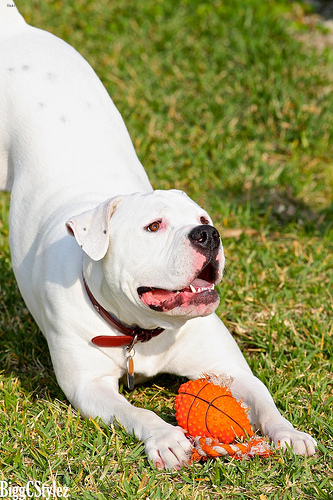

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


'a white dog playing with a ball'

In [23]:
display(all_images[1])
generate_caption(all_images[1])

## wrap it as a udf and apply to all

In [24]:
import torch
import pyarrow as pa

@udf(version="blip", cuda=True)
def caption_udf(image:bytes) -> str: 
    try:
        import geneva

        # load images and prepare for inputs
        image_stream = io.BytesIO(image)
        pil_image = Image.open(image_stream).convert("RGB")        
        answer = generate_caption(pil_image)
        return answer
    except:
        raise ValueException("problem in UDF") from e

## Use materialized view approach

In [25]:
# define the search query
mv_q = portrait_q.select({
    "image":"image", 
    "embedding": GenEmbeddings(),
    "caption_blip": caption_udf
})

In [26]:
# create the new materialized view table definition
try:
    db.drop_table("portraits")
except:
    pass 
mv_portraits = db.create_materialized_view("portraits", mv_q)
mv_portraits.to_arrow().to_pandas()

[2025-06-16T22:46:17Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


,__source_row_id,__is_set,image,embedding,caption_blip
0,0,False,None,None,None
1,1,False,None,None,None
2,9,False,None,None,None
3,14,False,None,None,None
4,16,False,None,None,None
5,18,False,None,None,None
6,25,False,None,None,None
7,30,False,None,None,None
8,35,False,None,None,None
9,36,False,None,None,None


In [27]:
mv_portraits.schema

__source_row_id: int64
__is_set: bool
image: binary
embedding: fixed_size_list<item: float>[512]
  child 0, item: float
  -- field metadata --
  virtual_column.udf_name: 'GenEmbeddings'
  virtual_column.udf_backend: 'DockerUDFSpecV1'
  virtual_column: 'true'
  virtual_column.udf_inputs: '["image"]'
  virtual_column.udf: '_udfs/c8e5d9b6c6e95ac4665598815ebf8278ee57a3220a55' + 20
caption_blip: string
  -- field metadata --
  virtual_column.udf_backend: 'DockerUDFSpecV1'
  virtual_column.udf_name: 'caption_udf'
  virtual_column: 'true'
  virtual_column.udf_inputs: '["image"]'
  virtual_column.udf: '_udfs/86d9c93cdcbdf986932c0a740b207f3c6534ab5d395c' + 20
-- schema metadata --
geneva::view::query: '{"base":{"vector_column":null,"vector":null,"filter' + 7424
geneva::view::base_table: 'images'
geneva::view::base_table_version: '7'
geneva::view::base_table_db_uri: '/tmp/quickstart-mv-wl2e8mz6'

In [28]:
# refresh to populate it
mv_portraits.refresh()
mv_portraits.to_arrow().to_pandas()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[2025-06-16T22:47:35Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
[2025-06-16T22:47:35Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


,__source_row_id,__is_set,image,embedding,caption_blip
0,0,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[0.007828293, 0.08610058, -0.14773259, -0.0489...",a fluffy white cat
1,1,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.014541363, 0.052883387, -0.109434016, 0.00...",a white dog playing with a ball
2,9,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.026703237, 0.019833094, -0.024848497, -0.0...",a small dog standing on a tiled floor
3,14,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[0.031546045, 0.0064448602, -0.080793664, -0.0...",a dog with blue eyes
4,16,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.024782635, -0.004416462, -0.07630157, -0.0...",a black dog sitting on a brick wall
5,18,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[0.0014912311, 0.060420346, -0.08611447, -0.02...",a cat laying on the floor
6,25,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.009739371, 0.013020973, -0.062082488, -0.0...",a dog with a black nose
7,30,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[0.0028448119, 0.061801914, -0.0071047014, -0....",a small dog sitting on a table
8,35,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[0.015526232, 0.12112971, -0.07019101, -0.0329...",a dog sitting on a wooden deck with its tongue...
9,36,False,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.005068455, 0.123329535, -0.09521951, 0.035...",woman holding a dog


## Do a lancedb vector search

In [29]:

# Load OpenCLIP
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
tokenizer = open_clip.get_tokenizer("ViT-B-32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()


INFO:root:Loaded ViT-B-32 model config.
INFO:root:Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [30]:
# query = "a brown dog with floppy ears"
# query = "a dalmatian"
# query = "australian blue heeler"
query = "a golden retriever"
query = "a greate dane"
query = "a chihuahua"
query = "fluffy cat"
tokens = tokenizer([query]).to(device)

with torch.no_grad():
    query_emb = model.encode_text(tokens)
    query_emb /= query_emb.norm(dim=-1, keepdim=True)
query_emb.shape # tensor

torch.Size([1, 512])

In [31]:
# do a lancedb search
import lancedb
lc = lancedb.connect(GENEVA_DB_PATH)
lt = lc.open_table("portraits")
rows = lt.search(query_emb.tolist(), 'embedding').to_list()
len(rows)

10

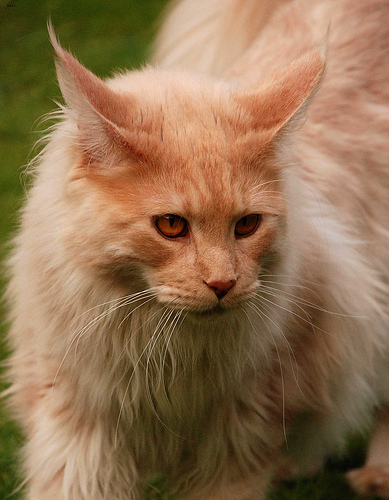

In [32]:
image_bytes = rows[0]["image"]
image_stream = io.BytesIO(image_bytes)
img = Image.open(image_stream).convert("RGB") 
img

# Shutdown

In [33]:
ray.shutdown()
